# Lab 1: Decision trees Regression and Bagging
### Univ.AI
### ML-2 Cohort-1


The goal of this lab is to predict the winner of the 2016 Presidential election (Trump vs. Clinton) in each county in the US, measured as 'votergap' = (trump - clinton) in percentage points. <br>
We do already know the answer to this now in 2021, but we intend to make a model to see how right or wrong our predictions are!

To do this, we consider several predictors and model a decision tree to perform regression and predict the dependent variable 'votergap'.
We then try to improve upon our simple Decision Tree model by implementing bagging.

In [1]:
#Import libraries
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import r2_score

## Part 1:  Reading and Exploring the data

We will be using 'county_level_election.csv' to model the outcome of the 2016 presidential election from various predictors.

We start by reading in the datasets and visualizing the main predictors for now.

In [3]:
#your code heredf = pd.read_csv("data/county_level_election.csv")
df.head()


,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


Perform an 80-20 train-test split on the dataframe to get your training and test data. Take only the following features in 'X': 'population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer'

In [6]:
#Split 80/20 train-test

#your code here
X = df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
y = df['votergap']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

Consider 1 variable, say minority, and plot the relationship between minority and the dependent variable.

Also plot this on a log scale to see if we can visualize it easier.


Note: We chose minority as it has the highest correlation with our target variable, you can also see this by printing out the correlation matrix using `sns.heatmap()` <br>
Remember not to leak any data while calculating the correlation!

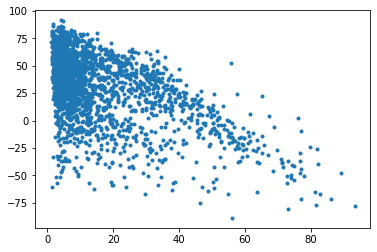

In [13]:
#Plot minorty vs votergap
#your code here
plt.plot(X_train["minority"],y_train,'.')

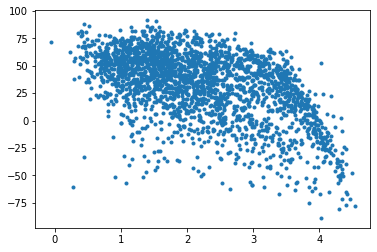

In [20]:
#Plot log(minorty) vs votergap
#your code here
plt.plot(np.log(X_train["minority"]),y_train.values,'.')

## Part 2: Decision Trees

### 2.1: Fitting with 1 predictor

First, let us fit, visualize, and interpret a tree with 1 predictor - minority.

You will need to build a Decisition tree Regressor and plot their predictions of the training data with the actual train data as seen below.
![goodreadsexample](https://drive.google.com/uc?export=view&id=1iTuS6SdohXYSzGm8hJYf1m4W3en0hIOt)


As you can see from above, we have tried out various max_depth and min_samples_split. <br>
Feel free to play around with sklearns DecisionTreeRegressor functions parameters.

In [53]:
print(np.shape(X_train[['minority']]))
parameters = {'max_depth': [1,2,4,6,8,10,12,14],'min_samples_split':[100,50,20,10,5,2]}
model = DecisionTreeRegressor()
g = GridSearchCV(model,parameters)
g.fit(np.array(X_train[['minority']]).reshape(-1,1),np.array(y_train).reshape(-1, 1))
print(g.best_params_)

(2452, 1)
{'max_depth': 4, 'min_samples_split': 50}


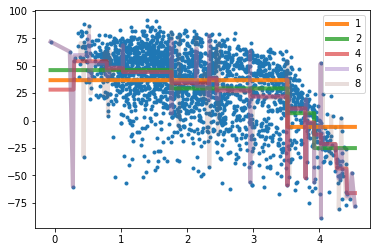

In [54]:
#your code here

x = X_train['minority'].values
o = np.argsort(x)
x = x[o]
y = y_train.values
y = y[o]

plt.plot(np.log(x),y,'.')
X = np.log(x).reshape(-1,1)
for i in [1,2,4,6,8]:
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(X, y)
    plt.plot(np.log(x), dtree.predict(X), label=str(i), alpha=1-i/10, lw=4)
plt.legend();

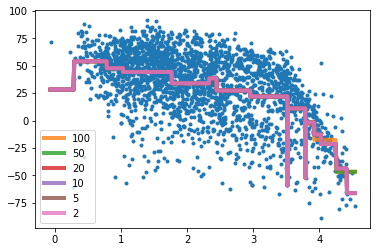

In [55]:
plt.plot(np.log(x),y,'.')
X = np.log(x).reshape(-1,1)
for i in [100,50,20,10,5,2]:
    dtree = DecisionTreeRegressor(max_depth=4, min_samples_split=i)
    dtree.fit(X, y)
    plt.plot(np.log(x), dtree.predict(X), label=str(i), alpha=0.8, lw=4)
plt.legend();

No handles with labels found to put in legend.


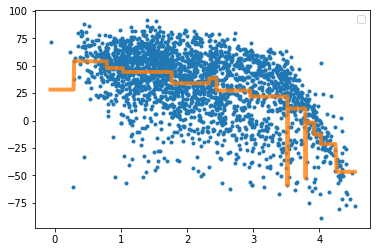

In [59]:
plt.plot(np.log(x),y,'.')
X = np.log(x).reshape(-1,1)
dtree = DecisionTreeRegressor(max_depth=4, min_samples_split=50)
dtree.fit(X, y)
plt.plot(np.log(x), dtree.predict(X), alpha=0.8, lw=4)
plt.legend();

### 2.2: Fitting with all predictors

Now, use all the predictors to model the Decision Tree.

Print out the actual training set and their predictions and compare these values to see how well your model has done. Save this as a dataframe.

Perform 5-fold cross-validation to determine what the best max_depth would be for a single regression tree using your entire training set and GridSearchCV().

Next, visualize these results by plotting the mean CV score and +/- 2 standard deviations across the validation sets.<br>
To do this, you will need to store the training scores, mean and standard deviations of the test score.

Your plot should look something like this: 

![goodreadsexample](https://drive.google.com/uc?export=view&id=1iAJf3AGbiri8r6B0nrtbRIgxhkF1yGsR)


In [61]:
depths = list(range(1, 21))

#your code here
train_scores = []
cvmeans = []
cvstds = []
cv_scores = []
for depth in depths:
    dtree = DecisionTreeRegressor(max_depth=depth)
    # Perform 5-fold cross validation and store results
    train_scores.append(dtree.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dtree, X=X_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

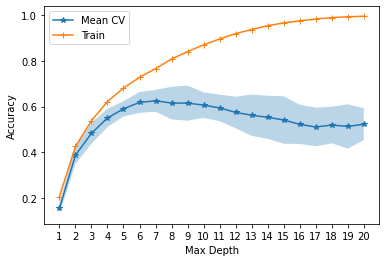

In [62]:
# plot means and shade the 2 SD interval

#your code here
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);

Choose the best max_depth based on the result of your cross validation and build your final model with all predictors and the optimal max_depth.<br>
Also print out the mean accuracy on the train and test data using the `score()` method from the DecisionTreeRegressor class.

**You can add pruning or any other techniques you have learnt in the lectures till now.**

In [ ]:
#your code here


print("Train accuracy:")
print("Test accuracy:")

In [65]:

dtree1=DecisionTreeRegressor()
path=dtree1.cost_complexity_pruning_path(X_train,y_train)
 
#Get the alpha and impurity values for the tree
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#Using a for loop, create one tree model per alpha from 'ccp_alphas' 
#and random state as 100
dtree_models=[]
for ccp_alpha in ccp_alphas:
    dtree1 = DecisionTreeRegressor(random_state=100,ccp_alpha=ccp_alpha)
    dtree1.fit(X_train,y_train)
    dtree_models.append(dtree1)

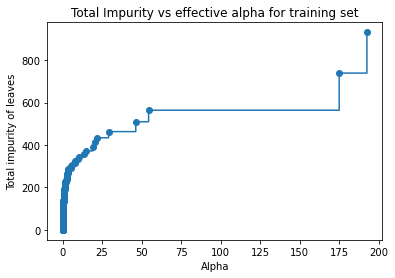

In [66]:
#Ploting the impurity of the trees as a function of alpha

fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")

ax.set_xlabel("Alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

In [67]:
#Calculate train and test scores for every tree model
train_scores = [model.score(X_train,y_train) for model in dtree_models]
test_scores = [model.score(X_test,y_test) for model in dtree_models]

In [70]:
### edTest(test_best) ###
#Find the minimum test score and plot the train and test accuracy of that tree
index_best_model = test_scores.index(max(test_scores))
best_model = dtree_models[index_best_model]

best_train_score=train_scores[index_best_model]
best_test_score=test_scores[index_best_model]

print('Training accuracy of best model: ',best_train_score)
print('Test accuracy of best model: ',best_test_score)

Training accuracy of best model:  0.6874402069436429
Test accuracy of best model:  0.6892609467822062


## Part 3: Bagging

You might still be overfitting in your previous model, we can now attempt to reduce the overfitting by implementing bagging. <br>
In this lab, we will be performing bagging for a decision tree modeled only on a single predictor as it is easier to visualize.

To do this, you will need to first bootstrap (resample data) and aggregate over all of the bootstrapped models. <br>
Plot your bagged models predictions in the training set along with the actual full training set to observe the predictions of your bagged models. <br>

Try implementing this without using sklearns `BaggingRegressor()`!

### 3.1: Bagging with 1 predictor

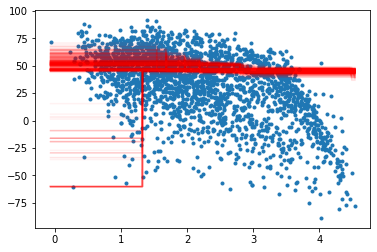

In [99]:
#your code here
ntrees = 500
estimators = []
R2s = []
y_pred = np.zeros((X_test.shape[0], ntrees))

plt.plot(np.log(x),y,'.')
for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=3)
    boot_xx, boot_y = resample(X_train[['minority']], y_train)
    estimators = np.append(estimators,simpletree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,simpletree.score(X_test[['minority']], y_test))
    y_pred[:,i] = simpletree.predict(X_test[['minority']])
    plt.plot(np.log(x), simpletree.predict(np.log(x).reshape(-1,1)), 'red', alpha=0.05)

### 3.2: Bagging with all predictors

Perform the same operations as you did above, except this time with all the predictors. 
In addition to this, calculate the average score of all of the individual trees and plot a histogram of the same. <br>
![goodreadsexample](https://drive.google.com/uc?export=view&id=1qBk8TMOygnIDmUCSzpkrrH7N0ulOrHSr)



Also print and calculate the score of the aggregated trees.

You need not plot the training set and their predictions as it gets harder to visualize so many dimensions.

In [100]:
#your code here
ntrees = 500
estimators = []
R2s = []
y_pred = np.zeros((X_test.shape[0], ntrees))

for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=4)
    boot_xx, boot_y = resample(X_train, y_train)
    estimators = np.append(estimators,simpletree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,simpletree.score(X_test, y_test))
    y_pred[:,i] = simpletree.predict(X_test)



Average R-squared score of the individual trees: 0.5840235578319717
R-squared score of the aggregated trees: 0.6770976370189485


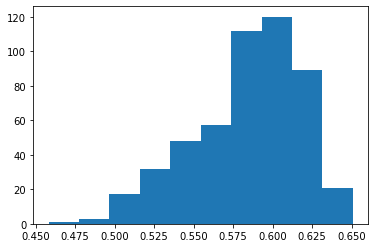

In [101]:
#Print and plot a histogram of the average R-squared score of all of the individual trees 
#Print and calculate the R-squared score of the aggregated trees
#your code here
plt.hist(R2s);
print("Average R-squared score of the individual trees:", np.mean(R2s))

bagged_test_predictions = np.mean(y_pred, axis=1)
print("R-squared score of the aggregated trees:",r2_score(y_test,bagged_test_predictions))

Question: What do you observe from the above histogram and the aAverage R-squared score of the individual trees and the R-squared score of the aggregated trees?

*Your answer here*

By averaging the predictions across the different Regression Tree models, R2 of aggregated trees through bagging  outperforms all of the separate individual models.